# Monte Carlo Methods

Monte carlo methods are a class of methods that use randomness to make it easier to solve deterministic problems. Specifally, we wish to compute integrals of the form
$$ \int f(x) p(x) dx$$
where $p$ is a probability density, i.e. a non-negative "function" that integrates to 1.

The idea of Monte-Carlo, is to observe that, if $X$ is a random variable distributed according to $p$, then
$$
\mathbb{E}[f(X)] = \int f(x) p(x)dx
$$
We can then estimate the expectation using the law of large numbers. We suppose that $X_1,\;X_2,\;X_3,\;\ldots$ are all random variables distributed according to $p$. Then the law of large numbers gives that
$$
\frac1n \sum_{i=1}^n f(X_i) \to \mathbb{E}[f(X_1)]=\int f(x)p(x)dx.
$$

A classical example of this, is to compute the area of the unit circle ($\pi$)
$$
\pi=\int_{D_1} 1 dx = \int_{[-1,1]\times[-1,1]} \chi_{D_1}(x) dx = 4 \mathbb{E[\chi_{D_1}(U_{[-1,1]\times[-1,1]})}],
$$
where $\chi_{D_1}$ is the indicator function of the unit disk.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

'error = 0.04240734641020705'

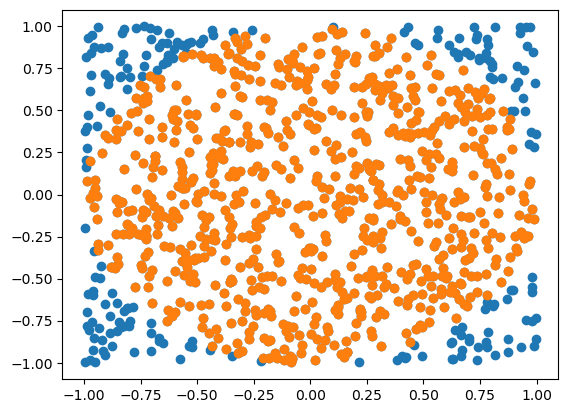

In [2]:
n = 1000;

xs = 2*np.random.rand(2,n)-1
plt.scatter(xs[0,:],xs[1,:])

ids = np.linalg.norm(xs,axis=0)<1
plt.scatter(xs[0,ids],xs[1,ids])

fn = 4*sum(ids)/n
'estimate = {}'.format(fn)
'error = {}'.format(fn-np.pi)

Let's look at how this converges with $n$

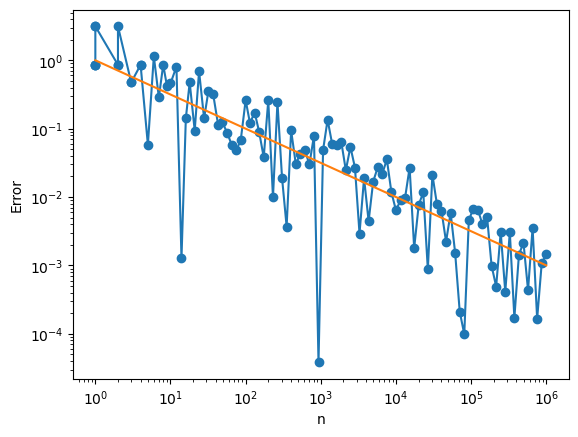

In [3]:
ns = np.int32(np.logspace(0,6,100))
errs = []
for n in ns:
    xs = 2*np.random.rand(2,n)-1
    ids = np.linalg.norm(xs,axis=0)<1
    errs.append((4*sum(ids)/n)-np.pi)
    
plt.loglog(ns,np.abs(errs),'o-')
plt.loglog(ns,1/np.sqrt(ns),'-')
plt.xlabel('n')
plt.ylabel('Error')
plt.show()

Let's look at why the error is decaying like $\frac{1}{\sqrt{n}}$. Let's let the estimator
$$
    \hat{f}_n = \frac1n \sum_n f(X_i).
$$
The variance of $\hat{f}_n$ is
$$
    \mathbb{E}\left[(\hat{f}_n-\hat{E}[f(X)])^2\right] = \frac{1}{n^2} \mathbb{E}\left[\left(\sum_{i=1}^n f(X_i)-\mathbb{E}[\hat{f}(X)]\right)^2\right] = \frac{1}{n^2} \sum_{i,j} \mathbb{E}\left[\left(f(X_i)-\mathbb{E}[\hat{f}(X)]\right)\left(f(X_j)-\hat{E}[f(X)]\right)\right].
$$
If we rearrange this a bit, we get
$$
\mathbb{E}\left[(\hat{f}_n-\hat{E}[f(X)])^2\right] =\frac{1}{n^2} \left(\sum_{i} \mathbb{E}\left[\left(f(X_1)-\mathbb{E}[\hat{f}(X)]\right)^2\right] +\sum_{i\neq j} \text{Cov}(f(X_i),(X_j)) \right)
$$
Since the $X_i$'s are independent, $\text{Cov}(f(X_i),(X_j))=0$ well $i\neq j$.
$$
\mathbb{E}\left[(\hat{f}_n-\hat{E}[f(X)])^2\right] =\frac{1}{n} \mathbb{E}\left[\left(f(X_1)-\mathbb{E}[\hat{f}(X)]\right)^2\right].
$$

If we take square root
$$
\sqrt{\mathbb{E}\left[(\hat{f}_n-\hat{E}[f(X)])^2\right]} =\frac{1}{\sqrt{n}} \sqrt{\mathbb{E}\left[\left(f(X_1)-\mathbb{E}[\hat{f}(X)]\right)^2\right]},
$$
we see that the average error will decay like $\frac{1}{\sqrt{n}}$.

This one over square root $n$ error is universal in Monte Carlo. It is both the advantage and the curse of Monte Carlo.

Suppose we are trying to compute an integral in $d$ dimensions using a $p$th order rule using $n$ points. The error is
$$
O\left( \sqrt[d]{n}^{-p}\right) = O\left( n^{-p/d}\right),
$$
which will be very slow when $d$ is large. This will be a lot smaller than the error of Monte Carlo when $d>2p$
$$
O\left(n^{-1/2} \right).
$$


## Importance sampling

Suppose we want to compute the integral of a highly concentrated function
$$
\int_{-\infty}^\infty e^{-10^4x^2}   dx = \frac{\sqrt{\pi}}{10^4} 
$$
We shall truncate to the interval $[-1,1]$, since the function is very small there.

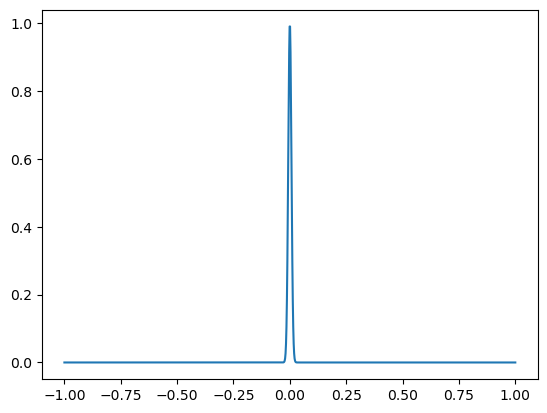

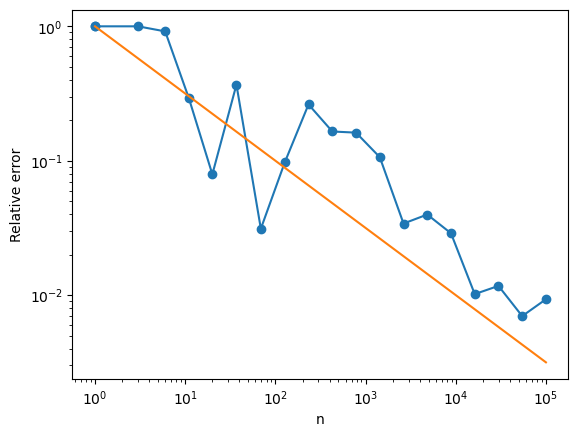

In [79]:
f = lambda x: np.exp(-1e4*x*x)
xs = np.linspace(-1,1,1000)
plt.plot(xs,f(xs))
plt.show()


true_int = np.sqrt(np.pi)/100

ns = np.int32(np.logspace(0,5,20))
ntrial = 10
errs = []
for n in ns:
    errs_samp = np.zeros(ntrial)
    for k in range(ntrial):
        xs = 2*np.random.rand(1,n)-1
        errs_samp[k] = ((2*np.sum(f(xs))/n)-true_int)/true_int
        
    errs.append(np.mean(errs_samp))
    
plt.loglog(ns,np.abs(errs),'o-')
plt.loglog(ns,1/np.sqrt(ns),'-')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.show()


We can increase the accuracy, we should use Monte Carlo samples where $f$ is large. If the samples $X_i$ are drawn from the pobability distribution $p$, then we compensate for this by 
$$
\int_{-\infty}^\infty f(x)dx = \int_{-\infty}^\infty \frac{f(x)}{p(x)} p(x)dx \approx \frac{1}{n} \sum_{i}\frac{f(x_i)}{p(x_i)} 
$$


We shall choose $p$ to be the density for a normal distrubtion: $p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp(-\frac{x^2}{2\sigma^2})$

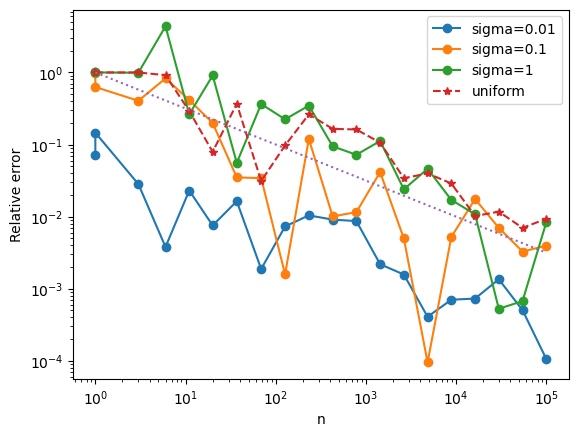

In [80]:
for sigma in [1e-2,1e-1, 1]:
    p = lambda x: np.exp(-x*x/2/sigma/sigma)/np.sqrt(2*np.pi*sigma**2)
    errs_import = []
    for n in ns:
        errs_samp = np.zeros(ntrial)
        for k in range(ntrial):
            xs = sigma * np.random.randn(1,n)
            est = np.sum(f(xs)/p(xs)) / n
            errs_samp[k] = (est-true_int)/true_int
        errs_import.append(np.mean(errs_samp))

    plt.loglog(ns,np.abs(errs_import),'o-',label='sigma={}'.format(sigma))

plt.loglog(ns,np.abs(errs),'*--',label='uniform')    
plt.loglog(ns,1/np.sqrt(ns),':')
plt.xlabel('n')
plt.legend()
plt.ylabel('Relative error')
plt.show()

We see that concentrating the samples at the peak of the function significantly decreases the error. This method is called "importance sampling".

## Markov Chain Monte Carlo (MCMC)
Sometimes we wish to compute
$$
\int f(x) p(x) dx
$$
but we can't directly sample from $p$. The idea will be to choose our samples $X_i$ to be samples from a Markov chain. i.e. $X_{i+1}$ is randomly generated from $X_i$. If we run it long enough, then the $X_i$'s will be distributed according to the stationary distribution of the Markov chain.

Our task is therefore to design a Markov chain whose stationary distribution is $p$.

### Metropolis-Hastings
We shall generate a sample $Y_{i+1}$ from $X_i$. i.e. $Y_{i+1}=X_i + \Delta_i$. 

Then we set $X_{i+1}=Y_{i+1}$ with probability $\text{min}(p(Y_{i+1})/p(X_i),1)$ and set $X_{i+1}=X_i$ otherwise.

You can check that the stationary probability is $p$. 

Note that we don't need the value of $p$, we only need the ratio, so $p$ need not be normalized.


Let's use this to compute
$$
\int_{-\infty}^\infty x^2 Z^{-1}e^{-V(x)} dx,
$$
where $V(x)=x^2$ and $Z=\int e^{-V(x)}$. The corresponding $p(x) = Z^{-1} e^{-V(x)}$.

Note that the samples are no longer independent. The covariance between samples will lower the effective number of samples, but the estimator will still converge.

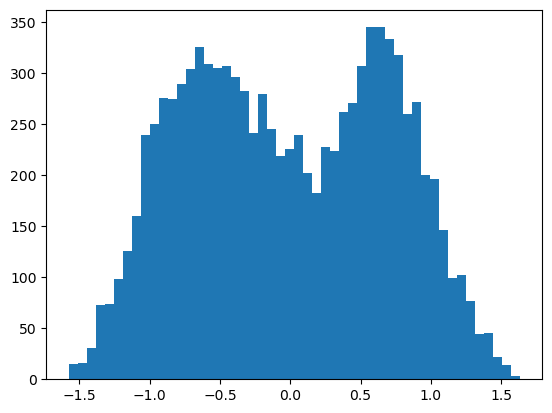

In [111]:
def MC_step(x,p):
    delta = 0.1
    y = x + delta*np.random.randn()
    prob = min(p(y)/p(x),1)
    if np.random.rand() < prob:
        x = y
    return x

V = lambda x: x**4-x**2
p = lambda x: np.exp(-V(x))

nburn_in = 1000
x = 0
for i in range(nburn_in):
    x = MC_step(x,p)
    
nsample = 10000
xs = [x]
for i in range(nsample):
    x = MC_step(x,p)
    xs.append(x)

xs = np.array(xs)
sum(xs*xs)/nsample
plt.hist(xs,bins=50)
plt.show()

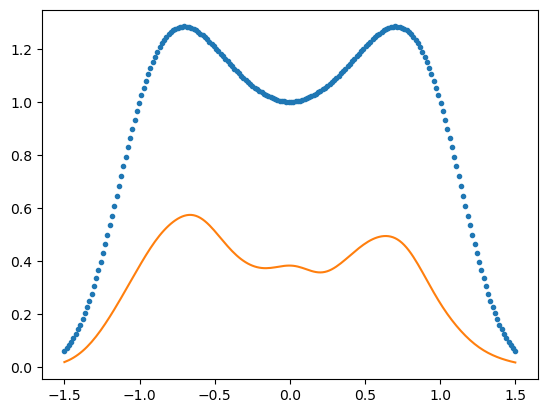

In [110]:
xx = np.linspace(-1.5,1.5,200)
plt.plot(xx,p(xx),'.')
kde = scipy.stats.gaussian_kde(xs)
plt.plot(xx,kde(xx))

In [ ]:
Such examples occur in statistical physics.